## OVERVIEW
---
* Data Visualization
 * Resort Hotel & City Hotel Comparison per roo type
 * Price vary over the year
 * Busiest Month
 * Market Segments Booking Percentage
 * Cancelled Bookings
 * Etc...
* Data Cleaning
* Weighing Important Features
* Data Pipelining
* XGBClassifier to Predict cancelled Bookings

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#get the data
df = pd.read_csv('hotel_bookings.csv')

### DATA BASIC INFORMATION
---

In [3]:
#show dataframe
df.head(3)

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  

[3 rows x 32 columns]

In [4]:
#show feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [4]:
#show basic stats on adr 
df['adr'].describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

### CHECK NULL VALUES
---

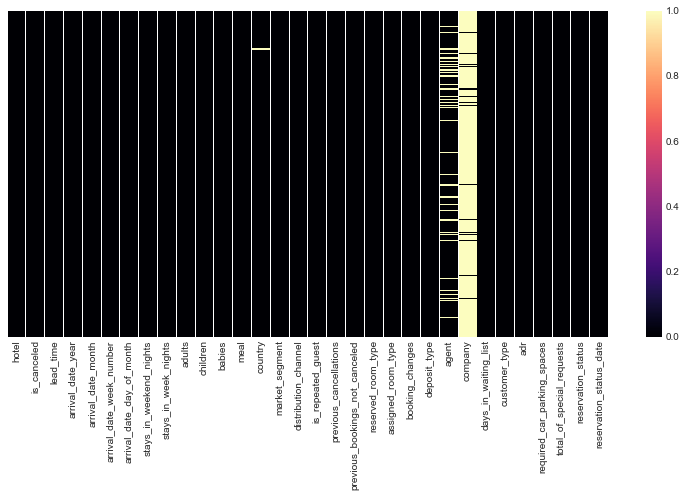

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='magma')

In [6]:
#show sum of null values per feature
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### DATA CLEANING
---

#### IMPUTING A VALUE

In [7]:
null_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
df_clean = df.fillna(null_replacements)

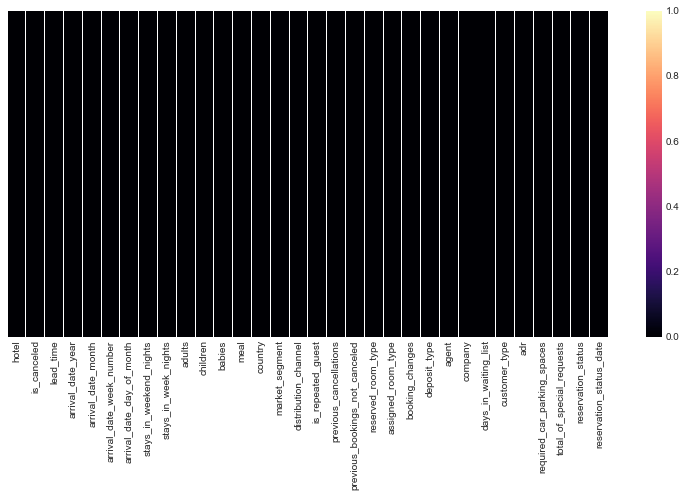

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(df_clean.isnull(), yticklabels=False, cmap='magma')

* No more null values

In [11]:
df_clean.replace('Undefined','SC', inplace=True)

In [12]:
no_guest_index = list(df_clean.loc[df_clean["adults"]
                   + df_clean["children"]
                   + df_clean["babies"]==0].index)
df_clean.drop(df_clean.index[no_guest_index], inplace=True)

In [13]:
# Separating Resort hotel and City hotel

res_hotel = df_clean[(df_clean['hotel'] == 'Resort Hotel') &
                     (df_clean['is_canceled'] == 0)]
res_city = df_clean[(df_clean['hotel'] == 'City Hotel') &
                     (df_clean['is_canceled'] == 0)]

In [14]:
# Cheking the the size of Resort hotel and City Hotel
print(res_hotel.shape)
print(res_city.shape)

(28927, 32)
(46084, 32)


## EDA
---

### GUEST PERCENTAGE PER COUNTRY
---

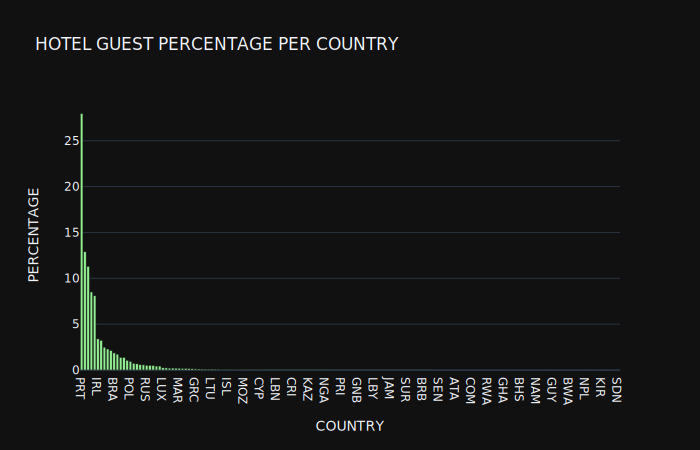

In [15]:
country_data = pd.DataFrame((df_clean[df_clean['is_canceled']==0]['country']).value_counts())
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round((country_data["Number of Guests"] / total_guests) * 100, 2)
country_data["country"] = country_data.index


fig = make_subplots(rows=1,cols=1)
fig.add_trace(go.Bar(x = country_data.country,
                     y = country_data['Guests in %'],
                     text = country_data['Number of Guests'],
                     marker_color='lightgreen'),row=1,col=1)

fig.update_yaxes(title='PERCENTAGE', row=1,col=1 )
fig.update_xaxes(title='COUNTRY', row=1,col=1 )
fig.update_layout(title='HOTEL GUEST PERCENTAGE PER COUNTRY', template='plotly_dark')


fig.show(renderer='svg')

#### VISUALIZATION WITH WORLD MAP

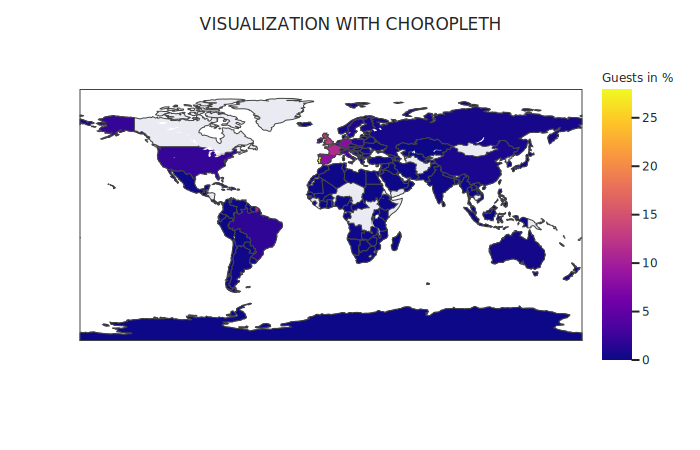

In [16]:
fig =px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title='VISUALIZATION WITH CHOROPLETH', template='seaborn')
fig.show(renderer='svg')

### HOTEL AVERAGE PRICES PER NIGHT
---

In [17]:
res_city['adr_pp'] = res_city['adr'] / (res_city['adults'] + res_city['children'])
res_hotel['adr_pp'] = res_hotel['adr'] / (res_hotel['adults'] + res_hotel['children'])

In [18]:
print('AVERAGE PRICE PER NIGHT AND PERSON \n')
print('Resort Hotel:   ', round(res_hotel.adr_pp.mean(),2), '€')
print('City Hotel:   ', round(res_city.adr_pp.mean(),2), '€')

AVERAGE PRICE PER NIGHT AND PERSON 

Resort Hotel:    47.49 €
City Hotel:    59.27 €


### RESORT AND CITY HOTEL PRICE COMPARISON PER ROOM TYPE
---

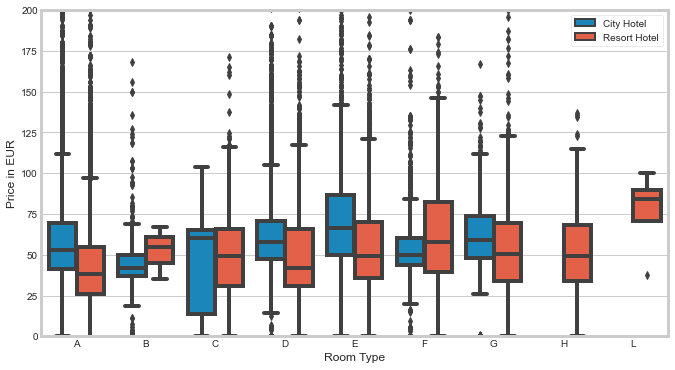

In [19]:
plt.figure(figsize=(10,6))

df_clean['adr_pp'] = df_clean['adr'] / (df_clean['adults'] + df_clean['children'])
guest_not_canc = df_clean[df_clean['is_canceled'] == 0]
hotel_room_prices = guest_not_canc[['hotel','reserved_room_type','adr_pp']].sort_values('reserved_room_type')

sns.boxplot(x = hotel_room_prices['reserved_room_type'], y=hotel_room_prices['adr_pp'], hue=hotel_room_prices['hotel'])

plt.ylim(0,200)
plt.ylabel('Price in EUR')
plt.xlabel('Room Type')
plt.legend(loc='upper right')

### PRICE VARY OVER THE YEAR

In [23]:
room_prices_monthly = guest_not_canc[['hotel','arrival_date_month','adr_pp']].sort_values('arrival_date_month')
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_monthly['arrival_date_month'] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=ordered_months, ordered=True)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

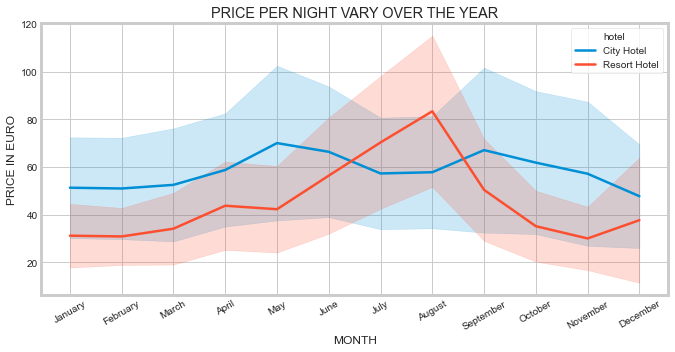

In [24]:
plt.figure(figsize=(10,5))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_monthly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title('PRICE PER NIGHT VARY OVER THE YEAR')
plt.xlabel('MONTH')
plt.ylabel('PRICE IN EURO')
plt.xticks(rotation=30)

### VISUALIZATION OF BUSIEST MONTH
---

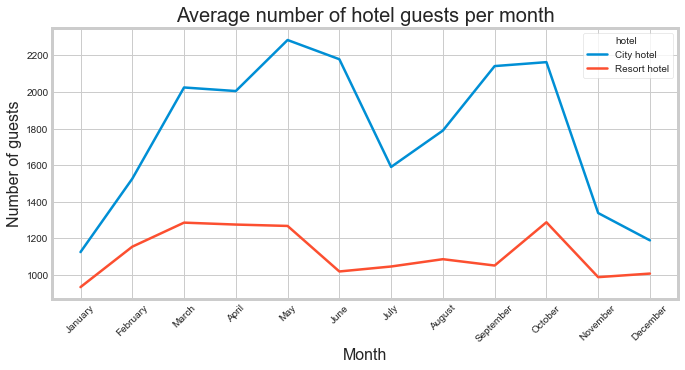

In [37]:
resort_guests_monthly = res_hotel.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = res_city.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

#SORT DATA BY MONTH
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

plt.figure(figsize=(10, 5))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

### VISUALIZATION OF HOW LONG DO GUEST STAYS AT THE HOTEL
---

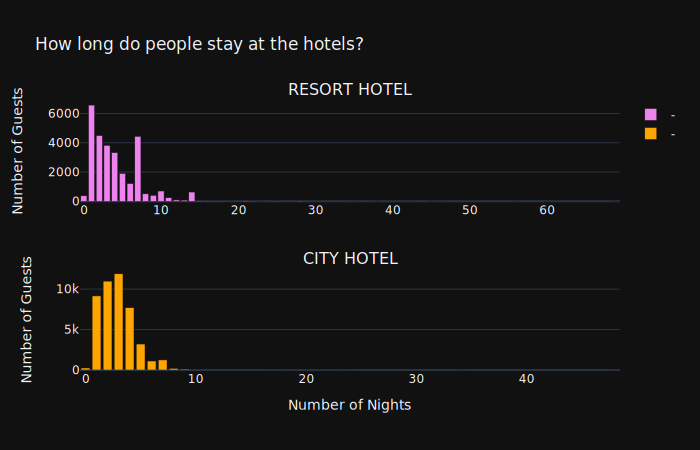

In [38]:
res_city['total_nights'] = res_city['stays_in_week_nights'] + res_city['stays_in_weekend_nights']
res_hotel['total_nights'] = res_hotel['stays_in_week_nights'] + res_hotel['stays_in_weekend_nights']

sorted_rh = res_hotel.groupby('total_nights').count()
sorted_ch = res_city.groupby('total_nights').count()

fig = make_subplots(rows=2,cols=1, subplot_titles=('RESORT HOTEL','CITY HOTEL'))

fig.add_trace(go.Bar(x=sorted_rh.index, y=sorted_rh.hotel, marker_color='violet',name='-'),row=1,col=1)
fig.add_trace(go.Bar(x=sorted_ch.index, y=sorted_ch.hotel,marker_color='orange',name='-'),row=2,col=1)

fig.update_yaxes(title='Number of Guests',row=1,col=1)
fig.update_yaxes(title='Number of Guests',row=2,col=1)
fig.update_xaxes(title='Number of Nights',row=2,col=1)
fig.update_layout(title='How long do people stay at the hotels?', template='plotly_dark')

fig.show(renderer='svg')



In [39]:

print('Average stay of Guest at the Resort Hotel:  ', round(res_hotel.total_nights.mean(),2), 'nights')
print('Average stay of Guest at the City Hotel:  ', round(res_city.total_nights.mean(),2), 'nights')

Average stay of Guest at the Resort Hotel:   4.14 nights
Average stay of Guest at the City Hotel:   2.92 nights


### MARKET SEGMENTS BOOKING PERCENTAGE

In [40]:
market_segmentation = df_clean['market_segment'].value_counts() / df_clean['market_segment'].count() *100

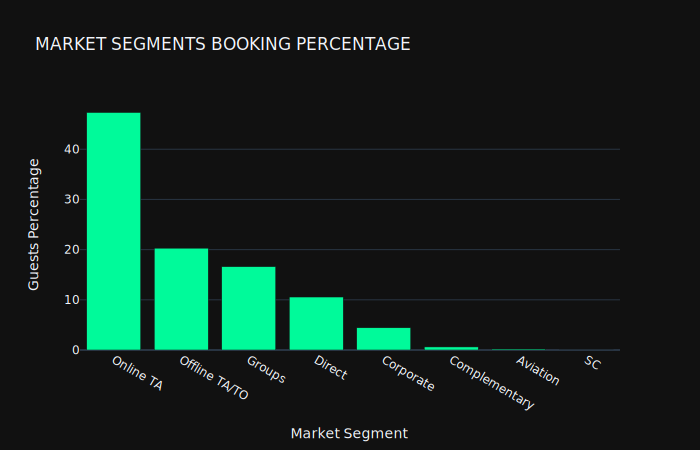

In [42]:
fig = go.Figure()

fig.add_trace(go.Bar(x=market_segmentation.index,
                     y=market_segmentation.values,
                     marker_color = 'rgb(0,250,154)'))

fig.update_layout(title = 'MARKET SEGMENTS BOOKING PERCENTAGE',template = 'plotly_dark',height=400)
fig.update_xaxes(title='Market Segment')
fig.update_yaxes(title='Guests Percentage')

fig.show(renderer='svg')

In [43]:
hotel_res_city = pd.concat([res_city, res_hotel])

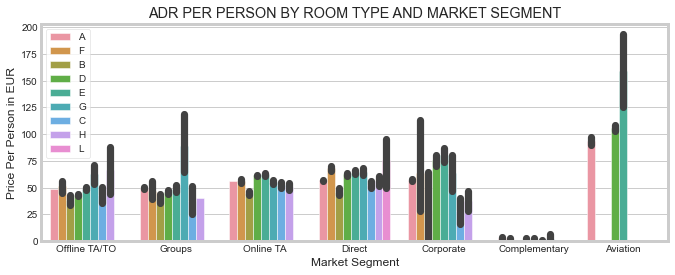

In [44]:
plt.figure(figsize=(10,4))

sns.barplot(x=hotel_res_city['market_segment'], y=hotel_res_city['adr_pp'], hue=hotel_res_city['reserved_room_type'])

plt.xlabel('Market Segment')
plt.ylabel('Price Per Person in EUR')
plt.title('ADR PER PERSON BY ROOM TYPE AND MARKET SEGMENT')
plt.legend()

### STATISTICAL INFO ON AVIATION AND NON-AVIATION MARKET SEGMENT
---

In [46]:
print('AIRLINE DATA')
df_clean[df_clean['market_segment']=='Aviation'][['is_canceled','adults','lead_time','adr_pp']].describe()

AIRLINE DATA


is_canceled      adults  lead_time      adr_pp
count   235.000000  235.000000  235.00000  235.000000
mean      0.221277    1.012766    4.47234  100.270979
std       0.415992    0.112503    4.61629   20.376689
min       0.000000    1.000000    0.00000    0.000000
25%       0.000000    1.000000    1.00000   95.000000
50%       0.000000    1.000000    3.00000   95.000000
75%       0.000000    1.000000    6.00000  110.000000
max       1.000000    2.000000   23.00000  193.500000

In [47]:
print('NON-AIRLINE DATA')
df_clean[df_clean['market_segment']!='Aviation'][['is_canceled','adults','lead_time','adr_pp']].describe()

NON-AIRLINE DATA


is_canceled         adults      lead_time         adr_pp
count  118975.000000  118975.000000  118975.000000  118971.000000
mean        0.371061       1.860878     104.306031      55.038212
std         0.483091       0.574499     106.888885      29.016998
min         0.000000       0.000000       0.000000      -3.190000
25%         0.000000       2.000000      18.000000      37.440000
50%         0.000000       2.000000      69.000000      49.500000
75%         1.000000       2.000000     161.000000      66.000000
max         1.000000      55.000000     737.000000    2700.000000

### TOTAL NUMBER OF BOOKINGS AND CANCELED BOOKINGS
---

In [48]:
print('Total Number of Bookings:  ' , df['is_canceled'].count())
print('Hotel Canceled Bookings:   ',
      round(df_clean[df_clean['is_canceled']==1]['hotel'].count() /
      df_clean['is_canceled'].count() *100,2), '%')

print('\nTotal Number Bookings (Resort Hotel):   ', df_clean[df_clean['hotel']=='Resort Hotel']['hotel'].count())
print('Resort Hotel Canceled Bookings:   ', round((df_clean[(df_clean['is_canceled'] == 1) & 
                                           (df_clean['hotel']=='Resort Hotel')]['hotel'].count() / 
                                           df_clean[df_clean['hotel']=='Resort Hotel']['hotel'].count())*100,2), '%')

print('\nTotal Number Bookings (City Hotel):   ', df_clean[df_clean['hotel']=='City Hotel']['hotel'].count())
print('City Hotel Canceled Bookings:   ', round((df_clean[(df_clean['is_canceled'] == 1) & 
                                           (df_clean['hotel']=='City Hotel')]['hotel'].count() / 
                                           df_clean[df_clean['hotel']=='City Hotel']['hotel'].count())*100,2), '%')

Total Number of Bookings:   119390
Hotel Canceled Bookings:    37.08 %

Total Number Bookings (Resort Hotel):    40047
Resort Hotel Canceled Bookings:    27.77 %

Total Number Bookings (City Hotel):    79163
City Hotel Canceled Bookings:    41.79 %


In [49]:
# Create a DateFrame with the relevant data:
res_book_per_month = df_clean.loc[(df_clean["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = df_clean.loc[(df_clean["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = df_clean.loc[(df_clean["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = df_clean.loc[(df_clean["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)


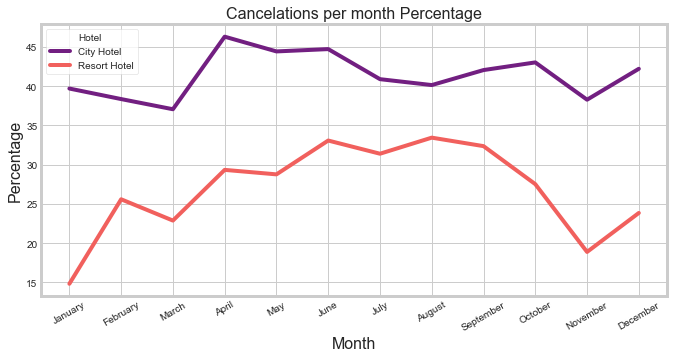

In [51]:


# show figure:
plt.figure(figsize=(10, 5))
sns.lineplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"],data=full_cancel_data,palette='magma',
            markers='o')
plt.title("Cancelations per month Percentage", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=30)
plt.ylabel("Percentage", fontsize=16)
plt.legend(loc="upper left")
plt.show()


### FEATURES CORRELATION TO CANCELATION OF BOOKINGS
---

In [52]:
cancel_feat = df_clean.corr()['is_canceled'].abs().sort_values(ascending=False)[1:]
cancel_feat.head(10)

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
Name: is_canceled, dtype: float64

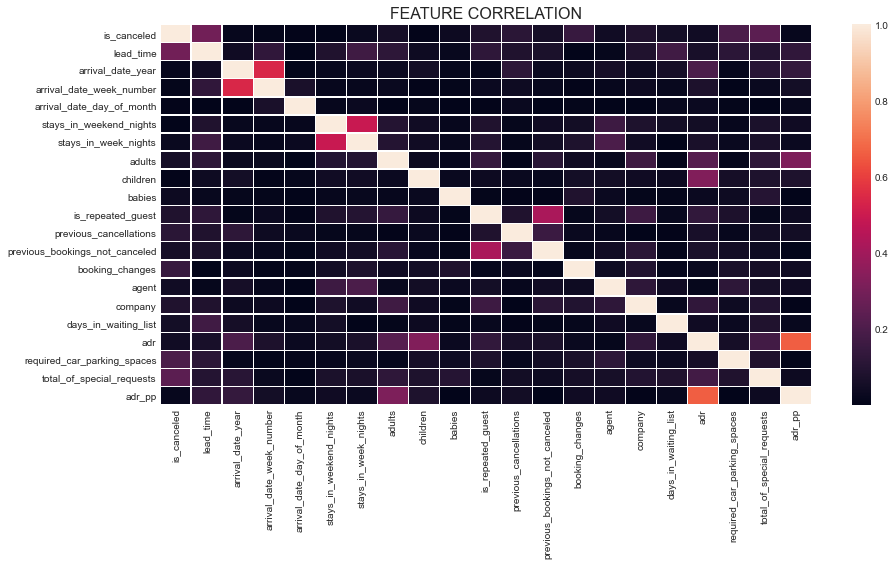

In [53]:
plt.figure(figsize=(13,7))
plt.title('FEATURE CORRELATION', fontsize=16)
sns.heatmap(df_clean.corr().abs(),linewidths=0.5)


In [54]:
df_clean.groupby('is_canceled')['reservation_status'].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

## MACHINE LEARNING SECTION
---

In [37]:
numerical_feat = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

categorical_feat = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

full_features = numerical_feat + categorical_feat
X = df_clean.drop('is_canceled', axis=1)[full_features]
y = df_clean['is_canceled']

In [38]:
#MISSING VALUES IMPUTATION
num_transformer = SimpleImputer(strategy='constant')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value='Unknown', strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#PREPROCESSOR NUMERICAL AND CATEGORICAL FEATURES
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_feat),
    ('cat', cat_transformer, categorical_feat)
])


### CANCELLATION PREDICTION MODEL USING XGBClassifier
---

In [39]:
xgb_model = XGBClassifier(n_jobs=100,random_state=101)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_mon

In [40]:
predictions = model.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

#### CLASSIFICATION REPORT

In [42]:
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     24808
           1       0.71      0.86      0.78     10955

    accuracy                           0.85     35763
   macro avg       0.82      0.85      0.83     35763
weighted avg       0.86      0.85      0.85     35763

[[21039  3769]
 [ 1572  9383]]


#### WEIGHING IMPORTANT FEATURES

In [84]:
dtc_model = DecisionTreeClassifier(random_state=0)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', dtc_model)
])

model.fit(X,y)
onehot_columns = list(model.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=categorical_feat))
feat_imp_list = numerical_feat + onehot_columns

df_imp_feat = eli5.formatters.explain_weights_df(
                     model.named_steps['model'],
                     feature_names=feat_imp_list)

In [86]:
#10 most important features
df_imp_feat.head(10)

feature    weight
0    deposit_type_Non Refund  0.238431
1                  lead_time  0.152254
2                        adr  0.099121
3  arrival_date_day_of_month  0.070619
4  total_of_special_requests  0.055201
5   arrival_date_week_number  0.050635
6                      agent  0.046518
7       stays_in_week_nights  0.040388
8   market_segment_Online TA  0.039407
9     previous_cancellations  0.032795